In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time
import numpy as np
import os

In [2]:

# Mean Value (Average Humerus length, and Standard deviation )
mu , sigma = 250, 7

# Sampling 15000 samples from the defined distribution
x_train_ulna = np.random.normal(mu, sigma, 15000)


#Adding random noise to data to improve stochasticity 
noise = np.random.normal(0, 5, x_train_ulna.shape)
x_train_ulna = x_train_ulna + noise

print(x_train_ulna)


[ 261.3187135   250.57740529  246.48061885 ...,  237.53848696  252.12656513
  248.16846356]


In [3]:
# C1 * Bone_length +  C2 = Height

#ULNA 

c1_ulna = 0.465 
c2_ulna = 61.610

def calculate_height(c1, c2, bone_length):
    
    return (c1* bone_length) + c2

# Generating GT label(Height) from random   
# Height corresponding to random bone length samples
y_train_ulna = []
for index, x in enumerate(x_train_ulna):
    y = calculate_height(c1_ulna, c2_ulna, x) + noise[index]
    
    y_train_ulna.append(y)
    
print(len(y_train_ulna))

15000


## Pre-Processing 

In [4]:
x_train = x_train_ulna
y_train = y_train_ulna
    
# Splitting train data and slicing except last 3000 values for validation  
x_train_float = np.array(x_train[1:len(x_train)-3000])
y_train_float = np.array(y_train[1:len(y_train)-3000])


# Slicing last 3000 samples to evaluate on them later
x_test_float =  np.array(x_train[-3000:])
y_test_float =  np.array(y_train[-3000:])

print(len(x_test_float))
print(len(y_test_float))


3000
3000


In [5]:
# Normalizing values to be in range (0 - 1) 

x_max = np.amax(x_train_float)
y_max = np.amax(y_train_float)
x_train_float = x_train_float / x_max
y_train_float = y_train_float / y_max

print(x_max, y_max)

283.735728213 213.077702971


Text(0.5, 0, 'x')

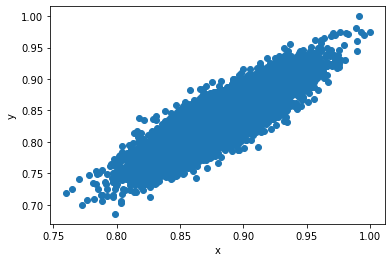

In [6]:
# Data Visualisation
# Plotting Sampled Data against height

plt.plot(x_train_float , y_train_float , 'o')
plt.ylabel("y")
plt.xlabel("x")

## Network

Text(0, 0.5, 'Loss')

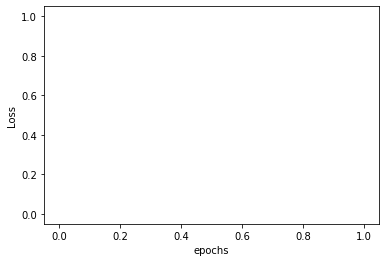

In [7]:
# 0) Prepare data
# Converting numpy arrays to pytorch tensors for input

X = torch.from_numpy(np.array(x_train_float, dtype='float32'))
Y = torch.from_numpy(np.array(y_train_float, dtype='float32'))


# Reshaping to a list of size (total samples, input SIZE) for input
y = Y.view((Y.shape[0], 1))
x  = X.view((X.shape[0], 1))

# 1) Model

input_size = 1
output_size = 1

# defining NN model 
class MyModelB(nn.Module):
    def __init__(self):
        super(MyModelB, self).__init__()
        self.fc1 = nn.Linear(1, 4)
        self.fc2 = nn.Linear(4 ,1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x
    
# creatig a model
model = MyModelB()

# 2) Loss and optimizer
learning_rate = 0.001

criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)  


# Batch Size 
Batch_size = 32
Datset_size= len(X)

iteration = Datset_size // Batch_size

# 3) Training loop
num_epochs = 0
losses = []
for epoch in range(num_epochs):
    # Forward pass and loss

    for i in range(iteration):
        x_batch = x[i*Batch_size:i*Batch_size+ Batch_size]
        y_batch = y[i*Batch_size:i*Batch_size+ Batch_size]
        y_predicted = model(x_batch)
        loss = criterion(y_predicted, y_batch)
        losses.append(loss)

        # Backward pass and update
        loss.backward()
        optimizer.step()
        # zero grad before new step
        optimizer.zero_grad()
        #print('iteration_{}_loss_ {}'.format(i, loss))

    if (epoch+1) % 2 == 0:
            print(f'epoch: {epoch+1}, loss = {loss.item():.5f}')

plt.plot(range(num_epochs*iteration), losses)
plt.xlabel("epochs")
plt.ylabel("Loss")

## Evaluation


In [20]:
# Evaluating using Mean Absolute Error
# scaling test data also between 0-1 to generate result (as the model was also trained with data scaled in range 0-1)

x_test = torch.from_numpy(np.array(x_test_float/x_max, dtype='float32'))
x_test = x_test.view(x_test.shape[0],1)

#Passing test samples through model
output = model.forward(x_test)

# Up-scaling output to real size
output *= y_max



# Calculating loss in each test sample and accumlating over all the test set.
total_loss = 0
for index, sample in enumerate(output):
    loss = abs(sample - y_test_float[index]) 
    #print(loss, sample, y_test_float[index])
    
    total_loss += loss
mean_absolute_error = total_loss / len(output)
print(mean_absolute_error)


tensor([6.1520], grad_fn=<DivBackward0>)


In [19]:
# Evaluating using Mean Squared Error

# Passing data through trained model
output = model.forward(x_test)

output *= y_max

total_loss = 0
for index, sample in enumerate(output):
    loss = torch.square(sample - y_test_float[index]) 
    #print(loss, sample, y_test_float[index])
    
    total_loss += loss
mean_absolute_error = total_loss / len(output)
print(torch.sqrt(mean_absolute_error))


tensor([7.1857], grad_fn=<SqrtBackward>)


## Saving Model

In [10]:
# Saving Trained Model

dirName = 'Trained_models/lower_arm_pytorch_'
PATH = 'Trained_models/lower_arm_pytorch_/lower_arm_pytorch_{}'.format(mean_absolute_error.item())

if not os.path.exists(dirName):
    os.mkdir(dirName)
    print("Directory " , dirName ,  " Created ")
else:    
    print("Directory " , dirName ,  " already exists")
        
#torch.save(model.state_dict(), PATH)
#the_model = torch.load(PATH)

Directory  Trained_models/lower_arm_pytorch_  already exists
